In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '-',
 3: '0',
 4: '1',
 5: '2',
 6: '3',
 7: '4',
 8: '5',
 9: '6',
 10: '7',
 11: '8',
 12: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    op = np.random.randint(2)
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    if op == 0:
        a, b = f(), f()
        q = '{}+{}'.format(a, b)
        ans = str(a + b)    
    else:
        num = [f(),f()]
        num.sort()
        a = num[1]
        b = num[0]
        q = '{}-{}'.format(a, b)
        ans = str(a - b)
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    query = q + ' ' * (MAXLEN - len(q))
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [8]:
print(questions[:5], expected[:5])

['796+83 ', '97-7   ', '5+779  ', '78-6   ', '98-1   '] ['879 ', '90  ', '784 ', '72  ', '97  ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [10]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]
train_y = y[:20000]
test_x = x[20000:]
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 13)
(18000, 4, 13)
Validation Data:
(2000, 7, 13)
(2000, 4, 13)
Testing Data:
(60000, 7, 13)
(60000, 4, 13)


In [11]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False  True False False False False False False
   False False]
  [False False False False False False False False False False False
    True False]
  [False False False False False False False False False  True False
   False False]
  [False False  True False False False False False False False False
   False False]
  [False False False False False False False  True False False False
   False False]
  [False False False False False False False False False False False
   False  True]
  [ True False False False False False False False False False False
   False False]]

 [[False False False False False False False False False  True False
   False False]
  [False False False False False False False False False False  True
   False False]
  [False False False False False False False False False False False
    True False]
  [False False  True False False False False False False False False
   False False]
  [False False False False  True False False False Fals

# Build Model

In [12]:
print('Build model...')
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

############################################
##### Build your own model here ############
############################################
n_chars = len(chars)
# create LSTM
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72704     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


# Training

In [13]:
import matplotlib.pyplot as plt
training = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/200
18000/18000 [==============================] - 8s 431us/step - loss: 1.9834 - acc: 0.3042 - val_loss: 1.8264 - val_acc: 0.3396
Epoch 2/200
18000/18000 [==============================] - 4s 197us/step - loss: 1.8070 - acc: 0.3365 - val_loss: 1.7973 - val_acc: 0.3354
Epoch 3/200
18000/18000 [==============================] - 3s 191us/step - loss: 1.7907 - acc: 0.3384 - val_loss: 1.7748 - val_acc: 0.3376
Epoch 4/200
18000/18000 [==============================] - 3s 186us/step - loss: 1.7656 - acc: 0.3428 - val_loss: 1.7628 - val_acc: 0.3444
Epoch 5/200
18000/18000 [==============================] - 3s 190us/step - loss: 1.7295 - acc: 0.3543 - val_loss: 1.7170 - val_acc: 0.3650
Epoch 6/200
18000/18000 [==============================] - 3s 183us/step - loss: 1.6891 - acc: 0.3728 - val_loss: 1.6827 - val_acc: 0.3723
Epoch 7/200
18000/18000 [==============================] - 3s 183us/s

18000/18000 [==============================] - 3s 180us/step - loss: 0.7295 - acc: 0.7372 - val_loss: 0.8692 - val_acc: 0.6718
Epoch 58/200
18000/18000 [==============================] - 3s 183us/step - loss: 0.7188 - acc: 0.7412 - val_loss: 0.8771 - val_acc: 0.6665
Epoch 59/200
18000/18000 [==============================] - 3s 168us/step - loss: 0.7083 - acc: 0.7445 - val_loss: 0.8695 - val_acc: 0.6714
Epoch 60/200
18000/18000 [==============================] - 3s 172us/step - loss: 0.7003 - acc: 0.7468 - val_loss: 0.8707 - val_acc: 0.6672
Epoch 61/200
18000/18000 [==============================] - 3s 178us/step - loss: 0.6818 - acc: 0.7554 - val_loss: 0.8454 - val_acc: 0.6780
Epoch 62/200
18000/18000 [==============================] - 3s 163us/step - loss: 0.6720 - acc: 0.7584 - val_loss: 0.8459 - val_acc: 0.6763
Epoch 63/200
18000/18000 [==============================] - 3s 162us/step - loss: 0.6573 - acc: 0.7634 - val_loss: 0.8429 - val_acc: 0.6782
Epoch 64/200
18000/18000 [=======

18000/18000 [==============================] - 5s 280us/step - loss: 0.0989 - acc: 0.9861 - val_loss: 0.3984 - val_acc: 0.8564
Epoch 116/200
18000/18000 [==============================] - 5s 289us/step - loss: 0.0950 - acc: 0.9866 - val_loss: 0.3950 - val_acc: 0.8505
Epoch 117/200
18000/18000 [==============================] - 5s 268us/step - loss: 0.0910 - acc: 0.9878 - val_loss: 0.4028 - val_acc: 0.8528
Epoch 118/200
18000/18000 [==============================] - 5s 268us/step - loss: 0.1069 - acc: 0.9796 - val_loss: 0.4359 - val_acc: 0.8427
Epoch 119/200
18000/18000 [==============================] - 5s 277us/step - loss: 0.1110 - acc: 0.9774 - val_loss: 0.3978 - val_acc: 0.8538
Epoch 120/200
18000/18000 [==============================] - 5s 282us/step - loss: 0.0838 - acc: 0.9894 - val_loss: 0.3925 - val_acc: 0.8555
Epoch 121/200
18000/18000 [==============================] - 4s 248us/step - loss: 0.0805 - acc: 0.9897 - val_loss: 0.4014 - val_acc: 0.8573
Epoch 122/200
18000/18000 [

18000/18000 [==============================] - 5s 298us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.3922 - val_acc: 0.8811
Epoch 174/200
18000/18000 [==============================] - 5s 293us/step - loss: 0.0112 - acc: 0.9999 - val_loss: 0.3920 - val_acc: 0.8803
Epoch 175/200
18000/18000 [==============================] - 5s 298us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.3967 - val_acc: 0.8806
Epoch 176/200
18000/18000 [==============================] - 5s 280us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.4004 - val_acc: 0.8796
Epoch 177/200
18000/18000 [==============================] - 5s 279us/step - loss: 0.0104 - acc: 0.9999 - val_loss: 0.4007 - val_acc: 0.8796
Epoch 178/200
18000/18000 [==============================] - 5s 279us/step - loss: 0.1333 - acc: 0.9597 - val_loss: 0.6359 - val_acc: 0.8181
Epoch 179/200
18000/18000 [==============================] - 5s 288us/step - loss: 0.1514 - acc: 0.9486 - val_loss: 0.4778 - val_acc: 0.8585
Epoch 180/200
18000/18000 [

Text(0.5,1,'3 digits add/sub')

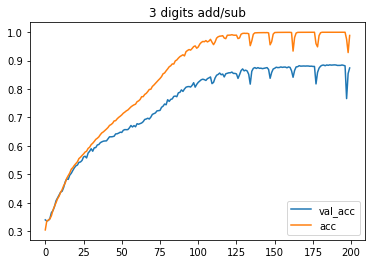

In [20]:
val_acc = training.history['val_acc']
acc = training.history['acc']
plt.figure()
plt.plot(val_acc, label = 'val_acc')
plt.plot(acc, label = 'acc')
plt.legend(loc='lower right')
plt.title('3 digits add/sub')

# Testing

In [21]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
#####################################################
correct_ct = 0
accuracy = 0
for i in range(len(test_x)):
    ind = np.random.randint(0, len(test_x))
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if correct == guess:
        correct_ct = correct_ct + 1
    else: 
        if i < 1000:
            print(i, ' Q', q[::-1] if REVERSE else q, end=' ')
            print('T', correct, end=' ')
            print(colors.fail + '☒' + colors.close, end=' ')
            print(guess)
accuracy = correct_ct/len(test_x)
print('accu:', accuracy)

MSG : Prediction
2  Q 967+1   T 968  ☒ 969 
3  Q 932-170 T 762  ☒ 752 
12  Q 437+411 T 848  ☒ 859 
13  Q 40+42   T 82   ☒ 81  
16  Q 960+84  T 1044 ☒ 1034
19  Q 377+312 T 689  ☒ 698 
23  Q 240+11  T 251  ☒ 261 
29  Q 708-8   T 700  ☒ 709 
30  Q 922-13  T 909  ☒ 919 
33  Q 336+62  T 398  ☒ 388 
35  Q 3+741   T 744  ☒ 745 
36  Q 616-499 T 117  ☒ 128 
39  Q 919-95  T 824  ☒ 823 
40  Q 523-94  T 429  ☒ 439 
41  Q 4+90    T 94   ☒ 96  
46  Q 14+136  T 150  ☒ 149 
47  Q 592-35  T 557  ☒ 547 
48  Q 150-38  T 112  ☒ 122 
52  Q 187+11  T 198  ☒ 290 
53  Q 657+319 T 976  ☒ 986 
54  Q 597-51  T 546  ☒ 536 
56  Q 69+481  T 550  ☒ 540 
58  Q 707+13  T 720  ☒ 710 
59  Q 924-247 T 677  ☒ 676 
62  Q 956-87  T 869  ☒ 879 
63  Q 105+817 T 922  ☒ 939 
65  Q 534-320 T 214  ☒ 204 
67  Q 594+280 T 874  ☒ 875 
68  Q 689+250 T 939  ☒ 928 
73  Q 762-744 T 18   ☒ 9   
77  Q 52+711  T 763  ☒ 773 
82  Q 830+988 T 1818 ☒ 1827
86  Q 345+56  T 401  ☒ 301 
87  Q 164+63  T 227  ☒ 226 
89  Q 886+23  T 909  ☒ 900 
91  Q

551  Q 42-7    T 35   ☒ 34  
553  Q 570-280 T 290  ☒ 380 
566  Q 596-64  T 532  ☒ 522 
568  Q 359-152 T 207  ☒ 217 
572  Q 732-708 T 24   ☒ 214 
576  Q 308-93  T 215  ☒ 214 
577  Q 979+9   T 988  ☒ 999 
581  Q 778-382 T 396  ☒ 496 
583  Q 407-80  T 327  ☒ 317 
586  Q 418-70  T 348  ☒ 349 
588  Q 653-3   T 650  ☒ 641 
589  Q 64+27   T 91   ☒ 92  
590  Q 692-646 T 46   ☒ 37  
591  Q 105-77  T 28   ☒ 27  
592  Q 596-135 T 461  ☒ 462 
593  Q 0+720   T 720  ☒ 721 
595  Q 915+93  T 1008 ☒ 101 
596  Q 348+345 T 693  ☒ 694 
597  Q 649+763 T 1412 ☒ 1312
599  Q 977+571 T 1548 ☒ 1530
602  Q 115+25  T 140  ☒ 131 
603  Q 212+551 T 763  ☒ 773 
606  Q 815+155 T 970  ☒ 960 
610  Q 897-95  T 802  ☒ 803 
611  Q 560+950 T 1510 ☒ 1511
612  Q 679-84  T 595  ☒ 585 
613  Q 903+88  T 991  ☒ 990 
615  Q 791-496 T 295  ☒ 395 
616  Q 171-90  T 81   ☒ 82  
619  Q 150-75  T 75   ☒ 74  
620  Q 930-81  T 849  ☒ 859 
628  Q 10+801  T 811  ☒ 821 
629  Q 343+463 T 806  ☒ 896 
632  Q 259-138 T 121  ☒ 128 
634  Q 62-43  

accu: 0.5943166666666667